# Sensitivity analysis

In [1]:
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType
import json
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
            .Builder() \
            .master("local") \
            .getOrCreate()

In [3]:
spark

In [4]:
df = spark.read.option("delimiter", "|").csv("../../../data/store_sales_sample.dat")

In [5]:
d = {
    '_c11': "ss_wholesale_cost",
    '_c12': "ss_list_price"
}

In [6]:
df = (df.withColumn("ss_wholesale_cost", F.col("_c11").cast(DoubleType()))
         .withColumn("ss_list_price", F.col("_c12").cast(DoubleType()))
         .select("ss_list_price", "ss_wholesale_cost"))

In [7]:
(df.write
     .option("header","true")
     .mode("overwrite")
     .parquet("../../../data/store_sales_sample_processed.parquet"))

In [8]:
column_pair = ["ss_list_price, ss_wholesale_cost"]
af = ["COUNT", "SUM", "AVG"]

In [9]:
df.show()

+-------------+-----------------+
|ss_list_price|ss_wholesale_cost|
+-------------+-----------------+
|        18.71|            11.41|
|       101.17|            63.63|
|       137.68|            80.52|
|         76.3|            57.37|
|        36.86|            25.08|
|       108.43|            93.48|
|        15.91|            10.68|
|       111.83|            84.72|
|        11.77|            11.54|
|         5.34|             4.57|
|        54.99|            31.07|
|        63.94|            52.41|
|       126.61|            67.71|
|        52.14|            27.16|
|       158.62|            93.86|
|        49.14|            35.87|
|         3.83|             2.27|
|        58.39|            53.09|
|        19.85|            17.12|
|        128.5|            88.02|
+-------------+-----------------+
only showing top 20 rows



## Build queries

In [10]:
min_max = df.agg(F.min(F.col('SS_LIST_PRICE')), F.max(F.col('SS_LIST_PRICE'))).rdd.collect()[0]

In [11]:
minimum, maximum = float(min_max[0]), float(min_max[1])
minimum, maximum

(1.03, 199.92)

In [219]:
def gen_range(mini, maxi, percentage, number=1):
    h = (maxi - mini) * percentage
    l = np.random.uniform(mini, maxi, number).tolist()
    return list(map(lambda x: (x, x + h) if x + h <= maxi else (x - h, x), l))

def query_gen(agg_funs, mini, maxi, percentage):
    agg_fun = agg_funs[np.random.randint(len(agg_funs))]
    a, b = gen_range(mini, maxi, percentage)
    return agg_fun, a, b

In [12]:
queries_per_af = 2
mini = minimum
maxi = maximum
range_percent = 0.10
queries = {
    af[0]: gen_range(mini, maxi, range_percent, queries_per_af),
    af[1]: gen_range(mini, maxi, range_percent, queries_per_af),
    af[2]: gen_range(mini, maxi, range_percent, queries_per_af)
}
  
# Writing to sample.json 
json_queries = json.dumps(queries) 
with open("../../../experiments/sensitivity_analysis_queries.json", "w") as outfile: 
    outfile.write(json_queries) 

NameError: name 'gen_range' is not defined

## Query range queries

In [224]:
queries_per_af = 5
mini = minimum
maxi = maximum
#####
range_percent = 0.001
#####
queries = {
    af[0]: gen_range(mini, maxi, range_percent, queries_per_af),
    af[1]: gen_range(mini, maxi, range_percent, queries_per_af),
    af[2]: gen_range(mini, maxi, range_percent, queries_per_af)
}
  
# Writing to sample.json 
json_queries = json.dumps(queries) 
with open("../../../experiments/sensitivity_analysis_queryRange{}_queries.json".format(range_percent), "w") as outfile: 
    outfile.write(json_queries) 

# Query Analysis

## Start and End

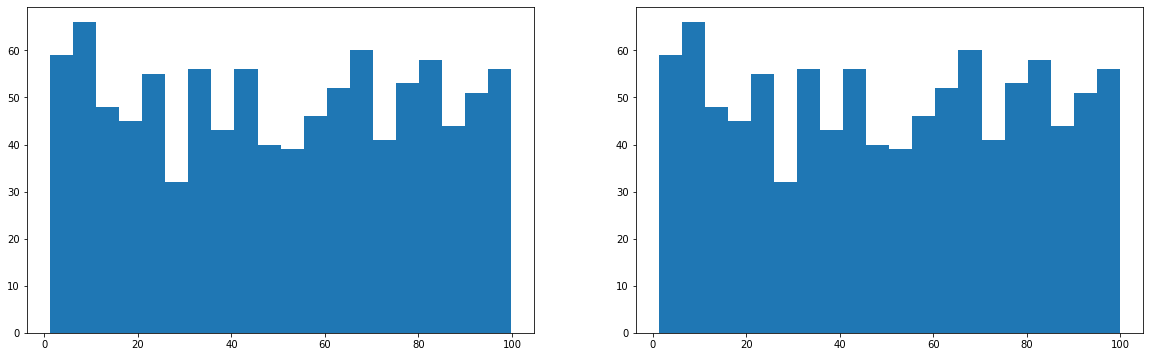

In [223]:
l = gen_range(mini, maxi, range_percent, 1000)
start = list(map(lambda x: x[0], l))
end = list(map(lambda x: x[1], l))
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].hist(start, bins = 20)
axes[1].hist(end, bins=20)
plt.show()

## Range

In [221]:
l = gen_range(mini, maxi, range_percent, 10)
ranges = list(map(lambda x: x[1] - x[0], l))
ranges

[0.09895999999999816,
 0.09895999999999816,
 0.09895999999999816,
 0.09896000000000527,
 0.09895999999999816,
 0.09895999999999816,
 0.09895999999999816,
 0.09895999999999816,
 0.09895999999999816,
 0.09896000000000527]